In [1]:
import networkx as nx
import igraph as ig
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
#from curved_edges import curved_edges

from cdlib import algorithms
import community
import leidenalg as lalg
from fa2 import ForceAtlas2
import bezier

from netneurotools import plotting
import bct


#ForceAtlas2 instantiated
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

# plt.style.use('ggplot')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}


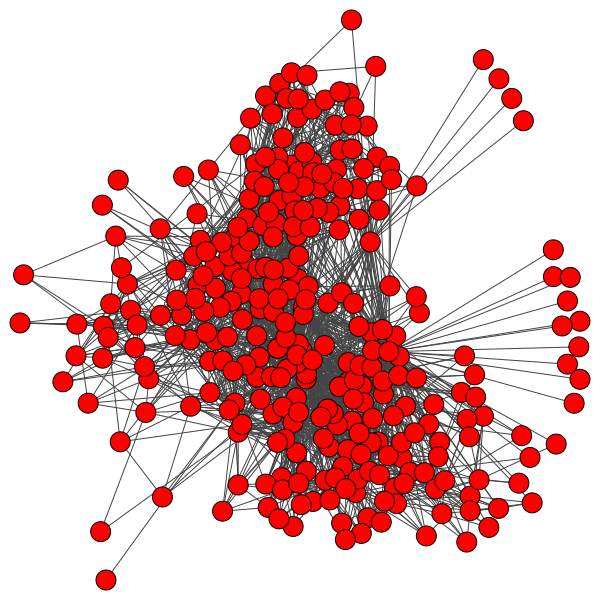

In [2]:
#read data

data = open("out.dimacs10-celegansneural", "rb")
G = nx.read_weighted_edgelist(data,comments='%')
data.close()


#Convert to igraph
iG = ig.Graph.from_networkx(G)
ig.plot(iG)

# METRICS

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


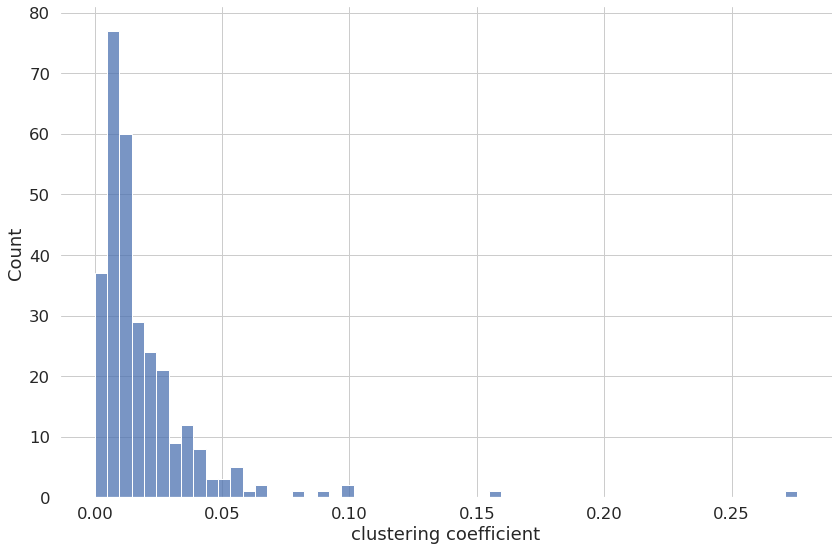

In [3]:
#clustering coefficients
cc = nx.clustering(G, weight='weight')
clust = pd.DataFrame(cc.values(), index = range(len(cc.items())), columns=['clustering coefficient'])
sns.set(font_scale=1.5)
sns.set_style({'axes.facecolor':'white', 'grid.color': '.8', 'font.family':'Times New Roman'})

sns.displot(data=clust, x='clustering coefficient', edgecolor=None, height=8, aspect=1.5)

plt.savefig('./Plots/clust.png')


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


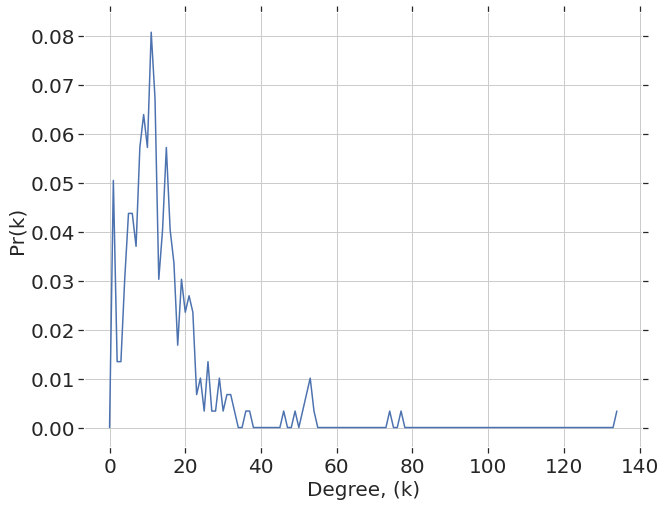

In [4]:
#Degrees

def degree_distribution(G):
    
    deg = dict(G.degree())
    deg = list(deg.values())  
    deg = np.array(deg) 
    
    maxk = np.max(deg)
    k = np.arange(0,maxk+1) #array of the possible degrees
    
    pk = np.zeros(maxk+1) # degree distribution p(k)
    for i in deg:
        pk[i] = pk[i] + 1
    pk = pk/sum(pk) # the sum of the elements of P(k) must to be equal to one
    
    return k,pk

k, pk = degree_distribution(G)

plt.figure(figsize=(10,8))
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on')
plt.plot(k, pk)
plt.xlabel('Degree, (k)', fontsize='20')
plt.ylabel('Pr(k)', fontsize='20')
plt.xticks(fontsize = '20'); plt.yticks(fontsize = '20')
plt.grid('on')
plt.savefig('./Plots/dd.png',bbox_inches='tight')
plt.show()


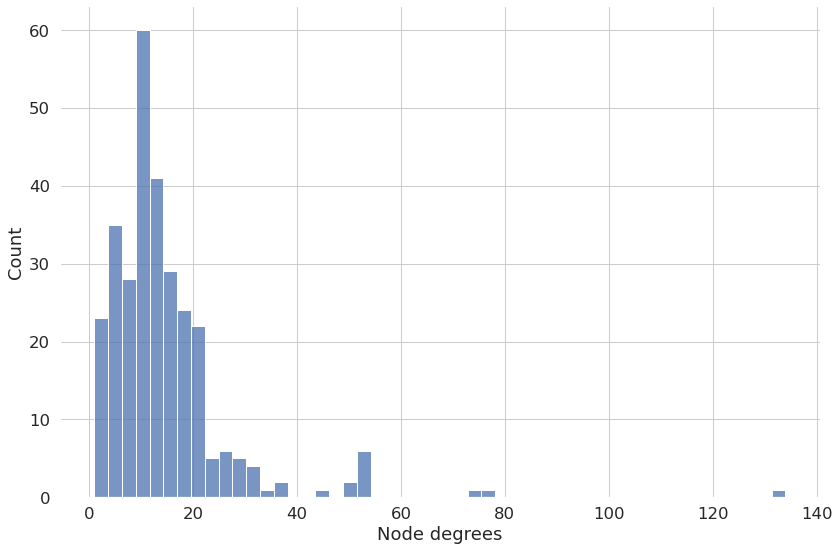

In [6]:
# using sns
deg = dict(G.degree)
deg_df = pd.DataFrame(deg.values(),index = range(len(deg.items())), columns=['Node degrees'])

# sns.displot(deg_df,legend=False)
sns.set(font_scale=1.5)
sns.set_style({'axes.facecolor':'white', 'grid.color': '.8', 'font.family':'Times New Roman'})

sns.displot(data=deg_df, x='Node degrees', edgecolor=None, height=8, aspect=1.5)


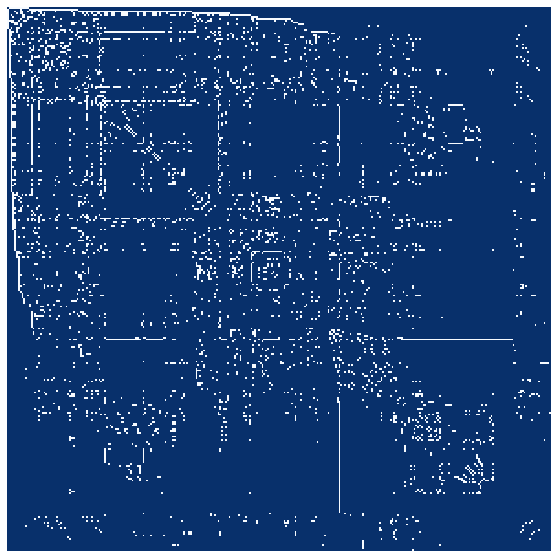

In [5]:
#Adjacency Matrix
cmap = plt.cm.Blues_r
iA = iG.get_adjacency()
iA = np.array(iA.data)

plt.figure(figsize=(10,10))
plt.imshow(iA,alpha=1.0, interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))
plt.xticks(fontsize='20');plt.yticks(fontsize='20')
plt.savefig('./Plots/adj2_matrix.eps')
plt.axis('off')
plt.show()

# COMMUNITY DETECTION


In this section, we are going to implement a community detection algorithm built on the Newman-Girvan configuration model. The quality function that will be optimized is given as:

$$Q = \frac{1}{2m} \sum_{ij} \left(A_{ij} - \frac{k_i k_j}{2m} \right)\delta(\sigma_i, \sigma_j)$$

We are going to use the Louvain and Leiden algorithms

# Louvain algorithm

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 722.13it/s]


BarnesHut Approximation  took  0.35  seconds
Repulsion forces  took  0.84  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


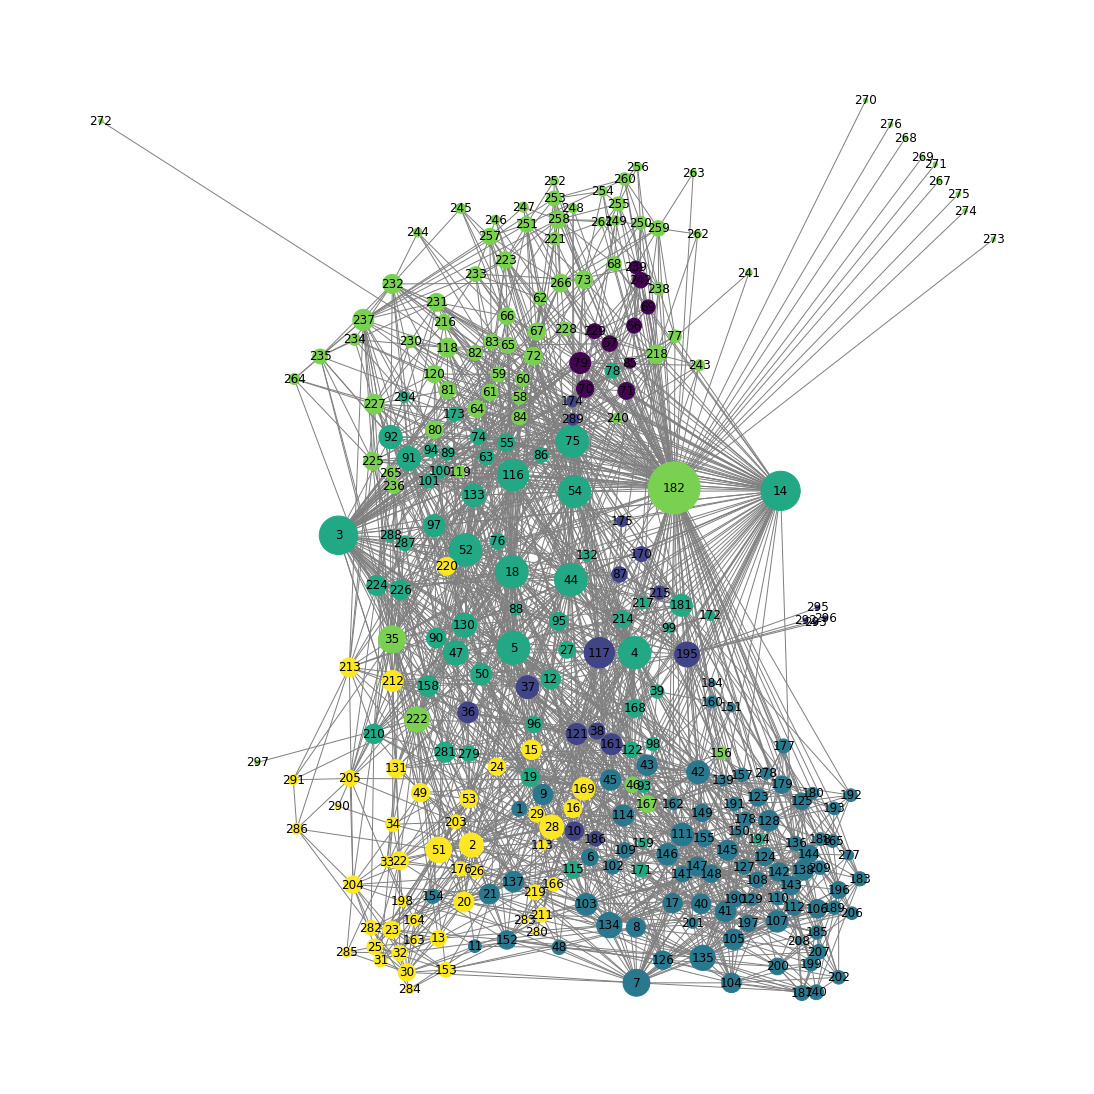

In [50]:
#Experimenting with the forceatlas layout
part_louvain = community.best_partition(G,weight='weight')
pos_louvain = forceatlas2.forceatlas2_networkx_layout(G,iterations=1000)
#forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)


plt.figure(figsize=(15,15))
node_weight = list(dict(G.degree()).values())

nx.draw(G, pos=pos_louvain, with_labels=True, node_color=list(part_louvain.values()),edge_color='grey',
       node_size=20*np.array(node_weight))

plt.savefig('./Plots/original_plt.png')

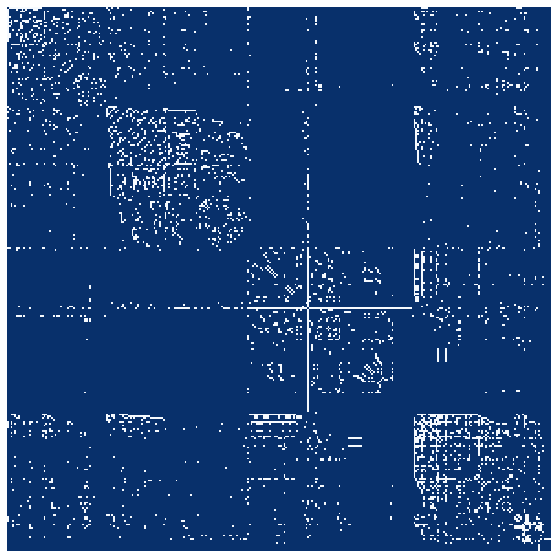

In [49]:
#Communities

louvain_graph = multiscale_graph(G,1.0)
lAd = nx.to_numpy_matrix(louvain_graph)
lAd = np.array(lAd.data)


plt.figure(figsize=(15,10))
plt.imshow(lAd, interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))
plt.xticks(fontsize='20');plt.yticks(fontsize='20')
plt.axis('off')
plt.show()

# Leiden Algorithm using iGraph package

We try to implement the Leiden algorithm here using the iGraph package written by the authors of Leiden algorithm.


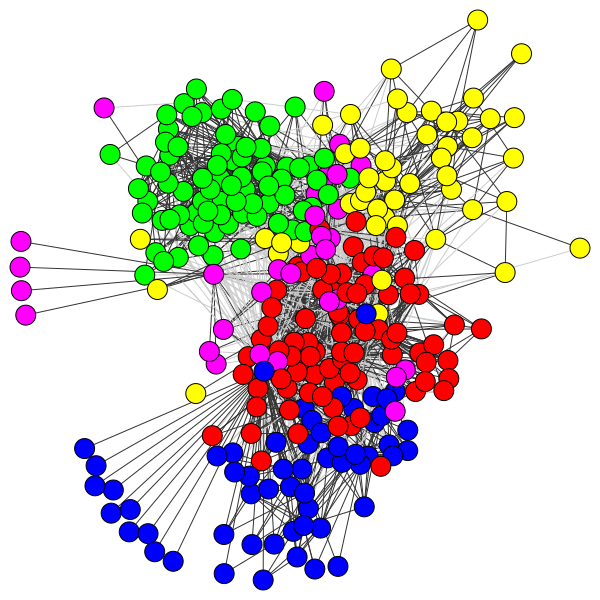

In [11]:
part_leiden = lalg.find_partition(iG, lalg.ModularityVertexPartition)
ig.plot(part_leiden)

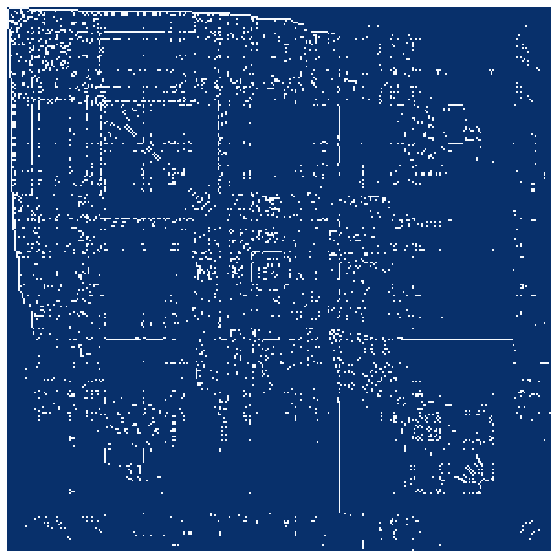

In [14]:
def lei_multiscale(G,partition):
    new_iG = ig.Graph()
    for comm in partition:
        for node in comm:
            #print(node)
            new_iG.add_vertex(node)
    
    edge_list = G.get_edgelist()
    new_iG.add_edges(edge_list)
    return new_iG


leiden_graph = lei_multiscale(iG,part_leiden)
lei_Ad = leiden_graph.get_adjacency()
lei_Ad = np.array(lei_Ad.data)

plt.figure(figsize=(15,10))
plt.imshow(lei_Ad,interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))
plt.xticks(fontsize='20');plt.yticks(fontsize='20')
plt.axis('off')
plt.show()

# Leiden algorithm using cdlib package


The challenge with this package is that it does not allow multi-scale community detection because it does not have the resolution parameter. Instead the parameter is set at its 'default' value of 1.0

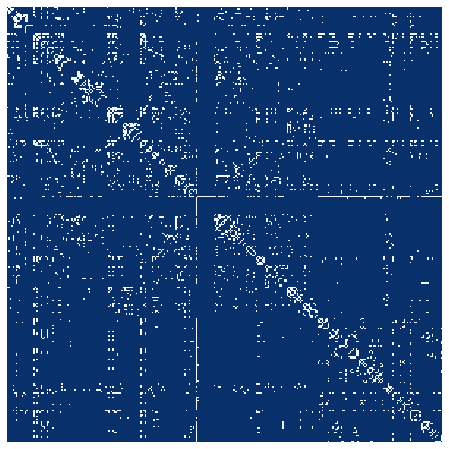

0.5031765896394075

In [24]:
part2 = algorithms.leiden(G,weights='weight')
com = part2.communities

Com_Gr2 = nx.Graph()

for c in com:
    Com_Gr2.add_nodes_from(c)

for s,e,w in G.edges(data=True):
    Com_Gr2.add_edge(s,e,weight=w['weight'])
    
Com_Gr2.edges(data=True)

Adc = nx.to_numpy_matrix(Com_Gr2)
Adc = np.array(Adc)
plt.figure(figsize=(10,8))
plt.imshow(Adj,interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))

mod = nx.algorithms.community.modularity(G,com)
plt.axis('off')
plt.show()
mod

In [ ]:
#curved_edges

# Produce the curves
# curves = curved_edges(G, positions)
# lc = LineCollection(curves, color='grey', alpha=0.05)
# plt.gca().add_collection(lc)
# plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)


In [16]:
# positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)

# # Produce the curves
# curves = curved_edges(G, positions)
# lc = LineCollection(curves, color='#2f3f2f', alpha=0.05)

# # Plot
# plt.figure(figsize=(20,20))
# nx.draw(G, positions, node_size=50, node_color='r', alpha=1.0)
# #plt.gca().add_collection(lc)
# #plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
# plt.savefig('./Plots/atlaslayout.png')
# plt.show()

# Multiscaling with Louvain algorithm

In [5]:
def multiscale_graph(G,res):
    partition = community.best_partition(G, resolution=res, weight='weight')
    sort_com = dict(sorted(partition.items(), key=lambda x: x[1]))#sort the partition
    
    #create a new graph
    Com_Gr = nx.Graph()
    
    #add nodes
    for node in sort_com.keys():
        Com_Gr.add_node(node)
        
    #add edges
    for s, e, w in G.edges(data=True):
        Com_Gr.add_edge(s, e, weight=w['weight'])
    
    return Com_Gr

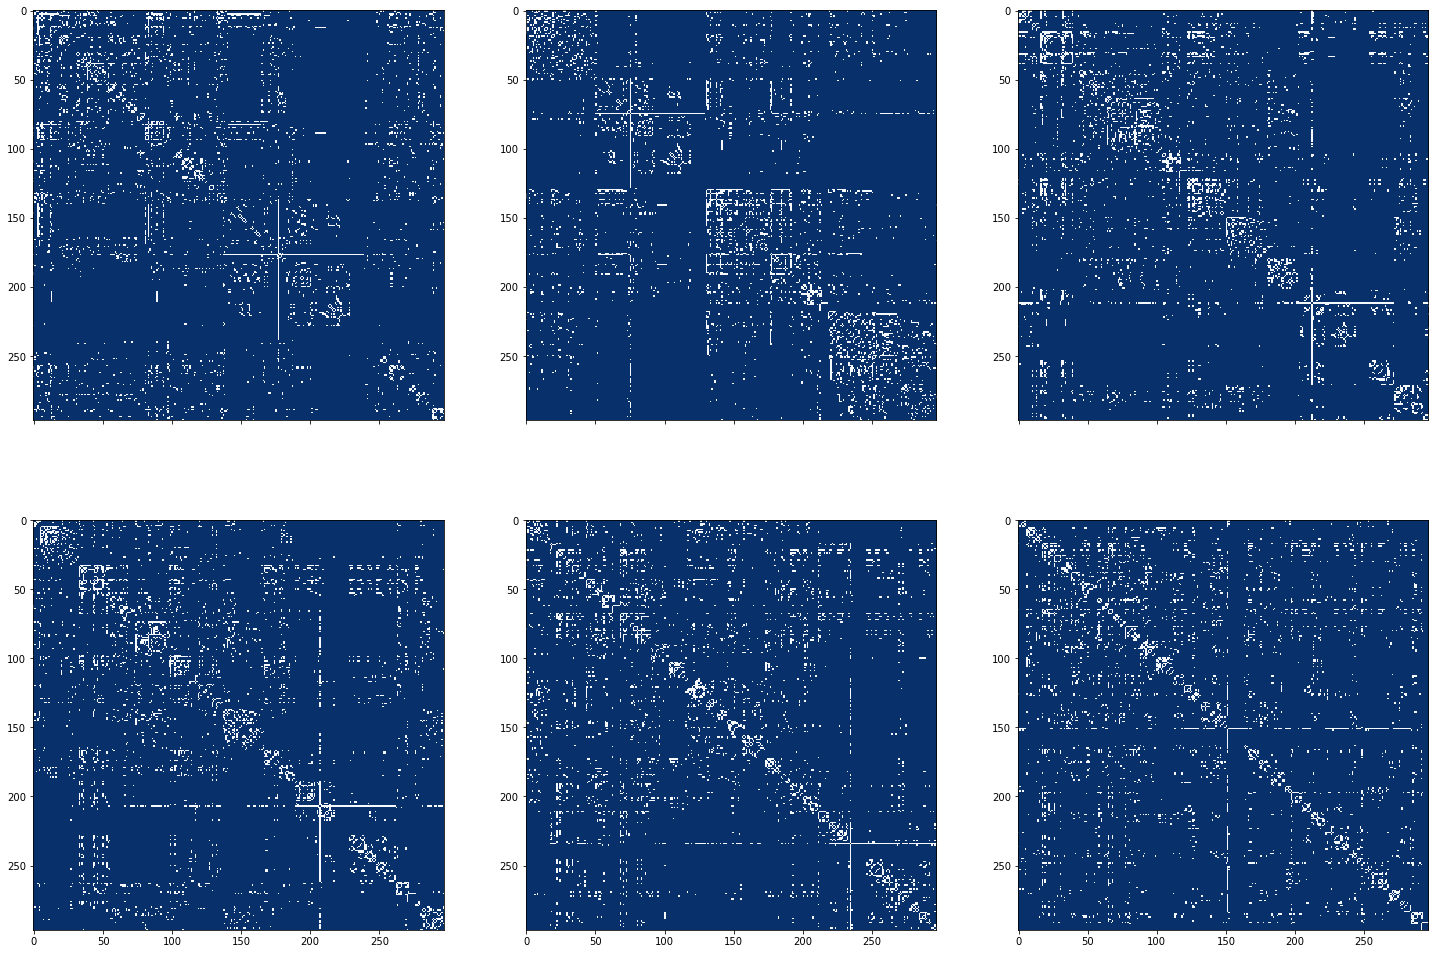

In [8]:
fig, axs = plt.subplots(2,3,figsize=(25,25), sharex=True);
fig.subplots_adjust(hspace=-.4)
axs = axs.ravel();
res = np.arange(0.0,6.0);i=0
# plt.xticks(fontsize='20');plt.yticks(fontsize='20');    

for r in res:
    Graph = multiscale_graph(G,r)
    Adj = nx.to_numpy_matrix(Graph)
    Adj = np.array(Adj)
    axs[i].imshow(Adj,interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))
    i+=1

plt.savefig('./Plots/multi_comm.pdf')
plt.show()

As $\gamma$ increases, the number of communities detected increased and the communities are arranged as dense connections along the diagonal.

# Multi-scaling using Louvain and Leiden algorithm

In [3]:
def com_adj(G, comm):
    '''This function takes a graph G, and a community of the graph G as an argument
    It creates a new Graph from G where the nodes of the new graph are arranged in the order of the community
    It returns the adjacency matrix of the new graph
    '''
    Gr = nx.Graph()
    
    for com in comm:
        Gr.add_nodes_from(com)
    for s,e,w in G.edges(data=True):
        Gr.add_edge(s,e,weight=w['weight'])
    A = nx.to_numpy_matrix(Gr,weight='weight')
    A = np.array(A)
    p = plt.imshow(A)
    
    return A

,$\gamma$,CPM_Modularity,No. of. Comm.,RBC_Modularity,No. of Comm.,Louvain Mod,Louvain nc
0,0.0,1.000000,1,1.000000,1,0.540651,57
1,1.0,0.365439,80,0.503552,5,0.489999,6
2,2.0,0.249782,122,0.341956,16,0.337619,14
3,3.0,0.172991,159,0.270591,25,0.266230,25
4,4.0,0.109217,178,0.220563,34,0.214501,37


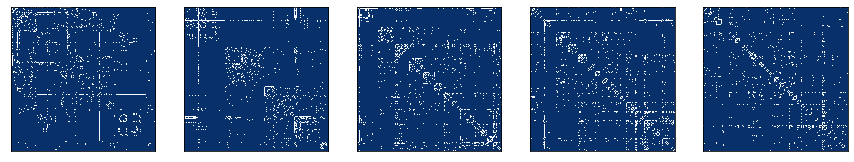

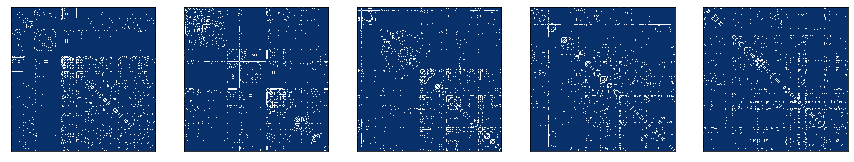

In [15]:
CPM_mod = []; RBM_mod = []; LOU_mod=[] #Modularity
CPM_nc = []; RBM_nc = []; LOU_nc=[] #Number of communities


CPM = lalg.CPMVertexPartition #CP model
RBC = lalg.RBConfigurationVertexPartition #RB model

res = [0.0,1.0,2.0,3.0,4.0]


def leiden_louvain_multiscale(G):
    '''
    This function takes an undirected weight graph G, and implements the optimizes the RB model and CP model
    using the Leiden algoritm. It equally optimizes the NG modularity function while scaling the resolution parameter
    $\gamma$'''
    
    le_fig, le_axs = plt.subplots(1,5,figsize=(15,10), sharex=True);
    lo_fig, lo_axs = plt.subplots(1,5,figsize=(15,10), sharex=True);
    #le_fig.subplots_adjust(wspace=.002)
    le_axs = le_axs.ravel();#lo_axs = lo_axs.ravel();
    plt.xticks(fontsize='20');plt.yticks(fontsize='20');
#     le_fig.suptitle('\n Leiden algorithm');lo_fig.suptitle('Louvain algorithm')
    
    mod = nx.algorithms.community.quality;#i=0
    
    for i in range(len(res)):
        
        #Leiden Algorithm
        #Community detection with CPM
        cpm_part = algorithms.cpm(G,weights='weight',resolution_parameter=res[i])
        cpm_mod_score = mod.modularity(G,cpm_part.communities, weight='weight', resolution=res[i]) #partition modularity
        cpm_nc = len(cpm_part.communities) #number of communities
        CPM_mod.append(cpm_mod_score); CPM_nc.append(cpm_nc)

        #community detection with RBM
        rbm_part = algorithms.rb_pots(G,weights='weight',resolution_parameter=res[i])
        rbm_mod_score = mod.modularity(G, rbm_part.communities, weight='weight', resolution=res[i]) #partition modularity
        rbm_nc = len(rbm_part.communities) #number of communities
        RBM_mod.append(rbm_mod_score); RBM_nc.append(rbm_nc)
        
        
#         #Louvain Algorithm
        part = algorithms.louvain(G,weight='weight',resolution=res[i])
        lou_nc = len(part.communities)
        lou_mod = mod.modularity(G,part.communities,weight='weight', resolution=res[i])
        LOU_mod.append(lou_mod), LOU_nc.append(lou_nc) 
        
        #Plot the adjacency matrix
        Le_Ad = com_adj(G,rbm_part.communities) #Leiden communities
        Lo_Ad = com_adj(G,part.communities) #Louvain communities
        le_axs[i].imshow(Le_Ad,interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))
        le_axs[i].get_xaxis().set_visible(False);le_axs[i].get_yaxis().set_visible(False)
        lo_axs[i].imshow(Lo_Ad,interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))
        lo_axs[i].get_xaxis().set_visible(False);lo_axs[i].get_yaxis().set_visible(False)
        
        #axs[i+3].imshow()
        #i+=1
    
    plt.savefig('./Plots/multiscaling.png')    
    df = pd.DataFrame({
        "$\gamma$":res,
        #'CPM':{
        'CPM_Modularity':CPM_mod,
        'No. of. Comm.': CPM_nc,
        #},
        #'RBC':{
        'RBC_Modularity':RBM_mod,
        'No. of Comm.':RBM_nc,
        'Louvain Mod': LOU_mod,
        'Louvain nc': LOU_nc
        #}
    },index=None)
    
    plt.savefig('./Plots/multiscale_comparison.png')
    plt.grid('off')

    return df

score = leiden_louvain_multiscale(G)
score

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


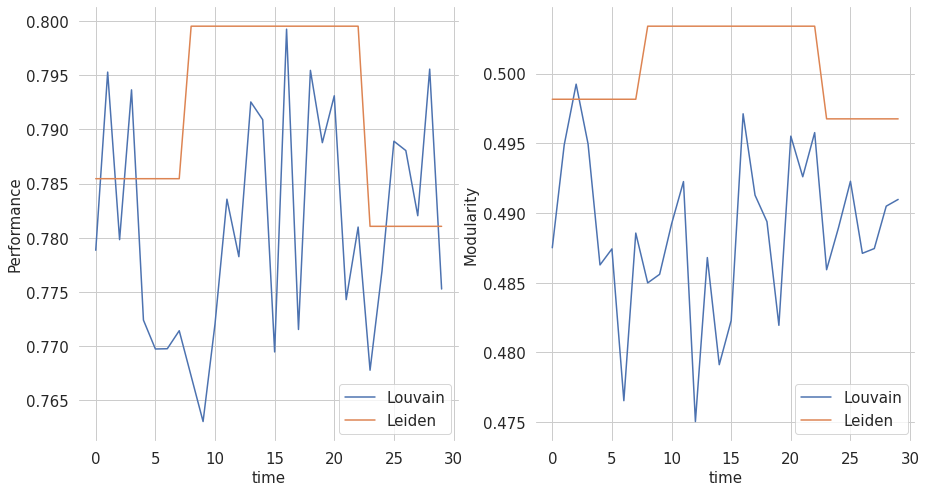

In [48]:
Lo = []; Le = [];#performance
Lo_mod = []; Le_mod=[]#modularity
nlo = []; nle=[]#Number of communities

sim = range(30)
for i in sim:
    lo_com = algorithms.louvain(G,weight='weight',resolution=1.0).communities #Louvain community
    le_com = algorithms.leiden(G,weights='weight').communities #Leiden community
    nlo.append(len(lo_com)); nle.append(len(le_com))
    
    #Performance
    lo_per = nx.algorithms.community.quality.partition_quality(G,lo_com)[1]
    le_per = nx.algorithms.community.quality.partition_quality(G,le_com)[1]
    
    #Modularity
    lo_mod = nx.algorithms.community.modularity(G,lo_com)
    le_mod = nx.algorithms.community.modularity(G,le_com)
    
    Lo.append(lo_per); Le.append(le_per)
    Lo_mod.append(lo_mod); Le_mod.append(le_mod)


plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(Lo,label='Louvain')
plt.plot(Le,label='Leiden')
plt.xticks(fontsize='15');plt.yticks(fontsize='15')
plt.xlabel('time',fontsize='15')
plt.ylabel('Performance',fontsize='15')
plt.legend(fontsize='15')

plt.subplot(122)
plt.xticks(fontsize='15');plt.yticks(fontsize='15')
plt.plot(Lo_mod,label='Louvain')
plt.plot(Le_mod,label='Leiden')
plt.xlabel('time',fontsize='15')
plt.ylabel('Modularity',fontsize='15')
plt.legend(fontsize='15')

plt.savefig('./Plots/louvainVSleiden.png')

Leiden have a higher perfomance value than Louvain. It is also more stable as opposed to the high volatility experienced in Louvain algorithm. You can be sure to have the same communities iteratively using Leiden algorithm, but Louvain does not guarantee that.

In [216]:
%timeit algorithms.leiden(G,weights='weight').communities

# %time algorithms.louvain(G,weight='weight').communities

14 ms ± 391 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [159]:
lou_com = list(part_louvain.keys())
#nx.algorithms.community.modularity(G,lou_com)
sort_com = dict(sorted(part_louvain.items(), key=lambda x: x[1]))#sort the partition
lou_com

community.modularity(part_louvain,G,weight='weight')

0.4944333355135607

ModularityVertexPartition:

$$Q = \frac{1}{2m} \sum_{ij} \left(A_{ij} - \frac{k_i k_j}{2m} \right)\delta(\sigma_i, \sigma_j)$$

CPMVertexPartition:

$$Q = \sum_{ij} \left(A_{ij} - \gamma \right)\delta(\sigma_i, \sigma_j)$$

RBConfigurationVertexPartition:

$$Q = \sum_{ij} \left(A_{ij} - \gamma \frac{k_i k_j}{2m} \right)\delta(\sigma_i, \sigma_j)$$

# Multiscale experiments

In [47]:
CPM_mod = []; RBM_mod = []; LOU_mod=[] #Modularity
CPM_nc = []; RBM_nc = []; LOU_nc=[] #Number of communities


CPM = lalg.CPMVertexPartition #CP model
RBC = lalg.RBConfigurationVertexPartition #RB model

res = [0.0,1.0,2.0,3.0,4.0,5.0]

def leiden(G):
    iG = ig.Graph.from_networkx(G)
    for r in res:
        
        #Leiden Algorithm
        #Community detection with CPM
        cpm_part = lalg.find_partition(iG,CPM,weights='weight',**{'resolution_parameter':r})
        cpm_mod_score = cpm_part.modularity #partition modularity
        cpm_nc = len(set(cpm_part.membership)) #number of communities
        CPM_mod.append(cpm_mod_score); CPM_nc.append(cpm_nc)

        #community detection with RBM
        rbm_part = lalg.find_partition(iG,RBC,weights='weight',**{'resolution_parameter':r})
        rbm_mod_score = rbm_part.modularity #partition modularity
        rbm_nc = len(set(rbm_part.membership)) #number of communities
        RBM_mod.append(rbm_mod_score); RBM_nc.append(rbm_nc)
        
        #Louvain Algorithm
        part = community.best_partition(G,weight='weight',resolution=r)
        lou_nc = len(set(part.values()))
        lou_mod = community.modularity(part,G,weight='weight')
        LOU_mod.append(lou_mod), LOU_nc.append(lou_nc)
    
    df = pd.DataFrame({
        "$\gamma$":res,
        #'CPM':{
        'CPM_Modularity':CPM_mod,
        'No. of. Comm.': CPM_nc,
        #},
        #'RBC':{
        'RBC_Modularity':RBM_mod,
        'No. of Comm.':RBM_nc,
        'Louvain Mod': LOU_mod,
        'Louvain nc': LOU_nc
        #}
    },index=None)
    
    return df

score = leiden(G)
score

,$\gamma$,CPM_Modularity,No. of. Comm.,RBC_Modularity,No. of Comm.,Louvain Mod,Louvain nc
0,0.0,0.000000,1,0.000000,1,0.347195,62
1,1.0,0.182732,84,0.378682,5,0.488430,6
2,2.0,0.113479,122,0.303128,14,0.440918,14
3,3.0,0.087100,154,0.242640,25,0.385667,26
4,4.0,0.065844,174,0.209500,34,0.328625,36
5,5.0,0.056847,187,0.188831,42,0.313318,41


# Quality Functions
$Q = \sum_{ij} \left(A_{ij} - \gamma \right)\delta(\sigma_i, \sigma_j)$

$Q = \sum_{ij} \left(A_{ij} - \gamma \frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \right)\delta(\sigma_i, \sigma_j),
$

$Q = \sum_{ij} \left(A_{ij} - \gamma p \right)\delta(\sigma_i, \sigma_j)$

$Q = \sum_{ij} \left(A_{ij} - \gamma \frac{k_i k_j}{2m} \right)\delta(\sigma_i, \sigma_j)$ rb_pots

$Q = \sum_{ij} \left(A_{ij} - \gamma \right)\delta(\sigma_i, \sigma_j)$ cpm

(-0.5, 296.5, 296.5, -0.5)

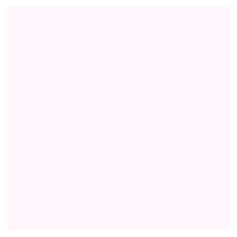

In [59]:
ipart = lalg.find_partition(iG, lalg.RBConfigurationVertexPartition, **{'resolution_parameter':100.0})

iGr = nx.Graph()

for com in ipart:
    iGr.add_nodes_from(com)

for s,e in iG.get_edgelist():
    iGr.add_edge(s,e)

#ax.matshow(subject_rel_alert.todense(), interpolation='nearest', cmap = cm.PuBu, norm=colors.LogNorm())

iAd = nx.to_numpy_matrix(iGr)
iAd = np.array(iAd, dtype=int)

# iAd = nx.adjacency_matrix(iGr).todense()
#plt.matshow(iAd,interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))
cmap = colors.ListedColormap(["blue", "orangered"]);cmap.set_bad("silver")
plt.matshow(iAd,interpolation='nearest',cmap = cm.PuBu, norm=colors.LogNorm() )
plt.axis('off')
#cm.

#colors.ListedColormap(["green", "orangered"])

# Louvain algorithm using bct package

<AxesSubplot:>

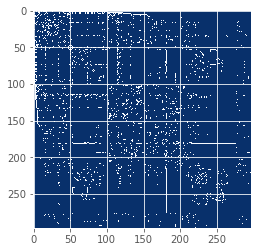

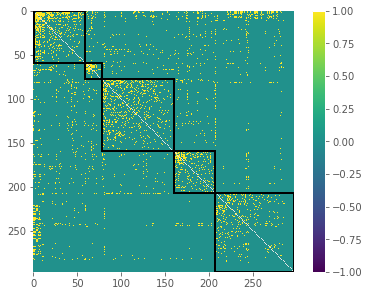

In [49]:
corr = nx.to_numpy_matrix(G)
corr = np.array(corr)
plt.imshow(corr,interpolation='nearest', cmap=cmap,norm=colors.PowerNorm(0.0020))

ci,Q = bct.community_louvain(corr)
node_cluster = np.array(algorithms.louvain(G).communities)
node_cluster


plotting.plot_mod_heatmap(corr,ci,vmin=-1, vmax=1, cmap='viridis')